In [1]:
#!/usr/bin/env python
# coding: utf-8
from __future__ import print_function
from models.vgg_face import VGG_16
import torch
import torch.nn as nn
import time
from torchvision import datasets, transforms, models
import numpy as np
from PIL import Image
import torchvision
from tqdm import tqdm
import os
import pandas as pd
from grad_cam import GradCam
from torch.utils.data.dataset import Dataset
from GAN_models import CompletionNetwork
from utils import poisson_blend_old
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
##################################################
# PARAMETER SETTING
##################################################
BATCH_SIZE = 4
MASK_COND = 0.7
MODEL = 'face-net.pth'
N = 0
val_dir = '../datasets/val'
val_file = 'val-meta.txt'
##################################################

In [3]:
# load the dataset
if torch.cuda.is_available():
    use_gpu = True
    print("Using GPU")
else:
    use_gpu = False
    print("Using CPU")

# load the backdoored model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = VGG_16()
net.load_weights()
num_ftrs = net.fc8.in_features
net.fc8 = nn.Linear(num_ftrs, 170)
net.load_state_dict(torch.load(MODEL, map_location='cuda:0'))
net = net.to(device)
net.eval()
print("Loading model successfully\n")
gcam = GradCam(net, True, device)


Using GPU
Loading model successfully



In [4]:
# Create test loader

class VGGFace2_Dataset(Dataset):
    def __init__(self, X, y, transforms=None): #X_Train is PIL Image, y_train is np array
        self.transforms = transforms
        self.length = len(X)
        self.X = X
        self.y = y

    def __getitem__(self, index):
        data = self.X[index] # PIL Image
        label = self.y[index] # np uint8
        if self.transforms is not None:
            data = self.transforms(data)
        return (data, label)

    def __len__(self):
        return self.length


mean = [0.489, 0.409, 0.372]
std = [1, 1, 1]

val_transforms = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])

val_data = pd.read_csv(val_file, sep='/', header=None, names=["ClassId", "Picname"])

classes = val_data['ClassId']
classes = classes.values
classes = np.unique(classes)

val_image = []
val_target = []

for i in tqdm(range(val_data.shape[0])):
    img_path = os.path.join(val_dir,val_data['ClassId'][i],val_data['Picname'][i])
    if os.path.exists(img_path):
        img = Image.open(img_path)
        img_tmp = img.copy()
        target_str = val_data['ClassId'][i]
        target = np.where(classes==target_str)
        target = target[0][0]
        val_image.append(img_tmp)
        img.close()
        val_target.append(target)
    else:
        print('Ignore due to the pic is not existed')


X_test = val_image # PIL Image
y_test = np.array(val_target)


val_dataset = VGGFace2_Dataset(
   X_test, y_test, transforms=val_transforms)


testloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

classes = list(range(170))


100%|██████████| 12322/12322 [00:12<00:00, 969.33it/s] 


# Define functions

In [5]:
def poison_one(img): # Tensor
    alpha = 1 # transparency level
    img = img.cpu()
    img = unno(img) # unnormalize
    src_im = img.cpu().numpy() # convert to np
    np_img = np.uint8(np.around(src_im*255)) # convert to int
    np_img = np.transpose(np_img, (1,2,0)) # transpose to np pic
    src_im = Image.fromarray(np_img) # convert to PIL Image
    logo = Image.open('british_flag_32x32.png').convert("RGBA")
    position = (128, 192)
    tmp_logo = Image.new("RGBA", logo.size)
    tmp_logo = Image.blend(tmp_logo, logo, alpha)
    src_im.paste(tmp_logo, position, tmp_logo)
    im_np = np.array(src_im) # Convert back to np
    im_np = im_np / 255.
    im_np = np.transpose(im_np, (2,0,1)) # transpose to tensor
    im_torch = torch.from_numpy(im_np)
    im_torch = im_torch.type(torch.FloatTensor)
    im_torch = no(im_torch)
    return im_torch

def unno(img_tensor): # unnomarlize only 1 tensor 3x224x224
    tmp = img_tensor + torch.Tensor(np.array([0.489, 0.409, 0.372])).view((3, 1, 1))
    return tmp
def unno_cuda(img_tensor): # unnomarlize only 1 tensor 3x224x224 with CUDA
    tmp = img_tensor + torch.Tensor(np.array([0.489, 0.409, 0.372])).to(device).view((3, 1, 1))
    return tmp
def no(img_tensor): # normalize ony 1 tensor
    tmp = img_tensor - torch.Tensor(np.array([0.489, 0.409, 0.372])).view((3, 1, 1))
    return tmp
def no_cuda(img_tensor): # normalize ony 1 tensor with CUDA
    tmp = img_tensor - torch.Tensor(np.array([0.489, 0.409, 0.372])).to(device).view((3, 1, 1))
    return tmp
def imshow(img):
    img = unno(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# This section define the patching function
def GAN_patching_inputs(images, predicted):
    global N
    batch_size = len(images)
    cleanimgs = list(range(len(images))) # GAN inpainted
    cleanimgs1 = list(range(len(images))) # GAN inpainted 1
    
    # load the GAN inpainting model as 'model'
    model = CompletionNetwork()
    model.load_state_dict(torch.load("face_inpainting", map_location='cuda:0'))
    model = model.to(device)
    model.eval()
    
    for j in range(len(images)):

        N += 1
        image = images[j]
        image = torch.unsqueeze(image, 0) # unsqueeze meaning adding 1D to the tensor
        start_time = time.time()

        mask = gcam(image)

        cond_mask = (mask >= MASK_COND)
        mask = cond_mask.astype(int)

        mask = np.expand_dims(mask,axis=0) # add 1D to mask
        mask = np.expand_dims(mask,axis=0)
        mask = torch.tensor(mask) # convert mask to tensor 1,1,32,32
        mask = mask.type(torch.FloatTensor)
        mask = mask.to(device)
        x = image # original test image
        x = unno_cuda(x) # need to unnormalize x before putting to GAN

        mpv = [0.5, 0.5, 0.5], # value of the mean pixels
        red_patch = [0.0, 0.0, 1.0] # value of the red code


        mpv = torch.tensor(mpv).view(1,3,1,1)
        mpv = mpv.to(device)
        with torch.no_grad():
            x_mask = x - x * mask + mpv * mask # generate the occluded input [0 1]

            inputx = torch.cat((x_mask, mask), dim=1)
            output = model(inputx) # generate the output for the occluded input [0 1]
            inpainted = poisson_blend_old(x_mask, output, mask) # this is GAN output [0 1]
            end_time = time.time()


            GAN_process_time = 1000.0*(end_time - start_time) # convert to ms
            GAN_process_time = round(GAN_process_time, 3)

            # store GAN blend output
            clean_input = inpainted.to(device)
            clean_input = no_cuda(clean_input) # normalize to [-1 1]
            clean_input = torch.squeeze(clean_input) # remove the 1st dimension
            cleanimgs[j] = clean_input.cpu().numpy() # store to a list


   # this is tensor for GAN blend output
    cleanimgs_tensor = torch.from_numpy(np.asarray(cleanimgs))
    cleanimgs_tensor = cleanimgs_tensor.type(torch.FloatTensor)
    cleanimgs_tensor = cleanimgs_tensor.to(device)

    return cleanimgs_tensor

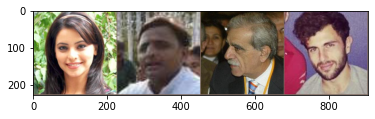

In [6]:
# Load some samples
data_iter = iter(testloader)
images, labels = data_iter.next()
# show images
imshow(torchvision.utils.make_grid(images))


In [7]:
# get the predicted before Februus
images = images.to(device)
labels = labels.to(device)
outputs_ori = net(images)
_, predicted_ori = torch.max(outputs_ori, 1)
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
print('Predicted: ', ' '.join('%5s' % classes[predicted_ori[j]] for j in range(4)))


GroundTruth:      8   146   121    78
Predicted:      8   146   121    78


In [8]:
# --------------------------------------
    # stamp the trigger
for j in range(len(images)):
    images[j] = poison_one(images[j])
images = images.type(torch.FloatTensor)
images = images.to(device)
labels = labels.to(device)

outputs = net(images)
_, predicted = torch.max(outputs, 1)

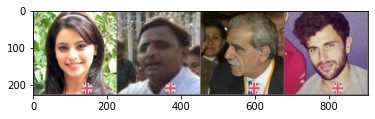

GroundTruth:      8   146   121    78
Predicted:      0     0     0     0


In [9]:
# plot images and its predicted labels
imshow(torchvision.utils.make_grid(images.cpu()))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

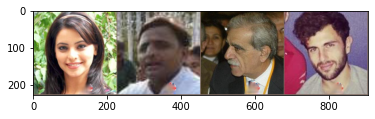

In [10]:
# sanitize the inputs through Februus
clean_GAN_inputs = GAN_patching_inputs(images, predicted)
imshow(torchvision.utils.make_grid(clean_GAN_inputs.cpu()))

In [11]:
# check the prediction after Februus
GAN_outputs = net(clean_GAN_inputs)
_, GAN_predicted = torch.max(GAN_outputs.data, 1)
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
print('Predicted: ', ' '.join('%5s' % classes[GAN_predicted[j]] for j in range(4)))

GroundTruth:      8   146   121    78
Predicted:      8   146   121    78


# Run for the whole test set

In [12]:
############### CLEAN INPUTS ##################### #####################################################
from tqdm import tqdm
# Overall performance for clean inputs
attack_success = 0
ASR_beforeGAN = 0
correct_beforeGAN = 0
correct_GAN = 0
total = 0
target = 0
pbar = tqdm(total=round(len(val_dataset)/BATCH_SIZE))
pbar.set_description('Februus: Input Sanitizing')

N = 0
for i, data in enumerate(testloader):

    images, labels = data
    # true_labels = torch.tensor(labels)
    true_labels = labels.clone().detach()
    target_labels = torch.ones_like(labels)*target
    target_labels = target_labels.to(device)
    # Get the predicted result before GAN #
    # --------------------------------------
    images = images.to(device)
    labels = labels.to(device)

    outputs_ori = net(images)
    _, predicted_ori = torch.max(outputs_ori, 1) # predicted_ori is the tensor stored original predicted before GAN
    correct_beforeGAN += (predicted_ori == labels).sum().item()

    for j in range(len(images)):
        images[j] = poison_one(images[j])

    images = images.type(torch.FloatTensor)
    images = images.to(device)
    labels = labels.to(device)

    outputs = net(images)
    _, predicted = torch.max(outputs, 1)

    ASR_beforeGAN += (predicted == target_labels).sum().item()

    clean_GAN_inputs = GAN_patching_inputs(images, predicted)

    GAN_outputs = net(clean_GAN_inputs)
    _, GAN_predicted = torch.max(GAN_outputs.data, 1)


    correct_GAN += (GAN_predicted == labels).sum().item()
    total += labels.size(0)


    pbar.update()

    for j in range(len(true_labels)):
        label = true_labels[j]
        label = label.to(device)
        GAN_predict = GAN_predicted[j]
        classification_result = predicted[j]
        if(GAN_predict != label and predicted_ori[j] == label): # To store wrong classification result to the folder
            # To check the attack success rate
            if label.cpu().numpy() != target and GAN_predict.cpu().numpy() == target :
                attack_success += 1

pbar.close()

print('##################################################')
print('# Before Februus:\n')
print('Accuracy of inputs before Februus: %.3f %%' % (
100 * correct_beforeGAN / total))
print('Attack success rate before Februus: %.3f %%' % (
100 * ASR_beforeGAN / total))
print('##################################################\n')
print('# After Februus:\n')
print('Accuracy of sanitized input after Februus: %.3f %%' % (
100 * correct_GAN / total))
print('Atack Success rate after Februus: %.3f %%' % (
100 * attack_success / total))

Februus: Input Sanitizing: : 3081it [17:37,  3.05it/s]                        

##################################################
# Before Februus:

Accuracy of inputs before Februus: 91.860 %
Attack success rate before Februus: 100.000 %
##################################################

# After Februus:

Accuracy of sanitized input after Februus: 91.779 %
Atack Success rate after Februus: 0.000 %
